# Validação do Sistema
Estes dados de validação aparecem no artigo submetido para SBBD 2013

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

In [21]:
from scipy import stats
def avaliar_corr(df, coluna_base):

    corr_df = pd.DataFrame(columns = ["r", "p"])

    for col in df:
        if pd.api.types.is_numeric_dtype(df[col]):
            r, p = stats.spearmanr(df[coluna_base], df[col])
            corr_df.loc[col] = [round(r,2), round(p,3) ]
    
    return corr_df

## Carregando datasets

In [4]:
#Dataset Arranjos e Municípios
df_arr_mun = pd.read_csv("../dados_final/2_dados_sem_enriquecimento/arr_mun.csv")
df_municipio = pd.read_csv("../dados_final/2_dados_sem_enriquecimento/municipio.csv")

#Dataset de estados
df_estado = pd.read_csv("../dados_final/2_dados_sem_enriquecimento/estado.csv")

#Dataset probabilidades
df_prob = pd.read_csv("./arr_calculo_qtd_fluxo.csv")

#Dataset casos iniciais (Alpha)
df_alpha = pd.read_csv("./brazil_covid19.csv")

#Dataset casos Gamma
# Carregando lista de arquivos .tsv
path = "../data_fiocruz"
tsv_files = glob.glob(os.path.join(path, "*.tsv"))
df_list = []
for f in tsv_files: 
    df_list.append(pd.read_csv(f, sep='\t'))
# Juntando dados em um único dataframe
df_gamma = pd.concat(df_list)

### Tratamento de dados

Criando DF de capitais

In [5]:
list_capital = ["Aracaju","Belém","Belo Horizonte","Boa Vista","Brasília","Campo Grande","Cuiabá","Curitiba","Florianópolis","Fortaleza","Goiânia","João Pessoa","Macapá","Maceió","Manaus","Natal","Palmas","Porto Alegre","Porto Velho","Recife","Rio Branco","Rio de Janeiro","Salvador","São Luís","São Paulo","Teresina","Vitória"]
list_uf = ["SE","PA","MG","RR","DF","MS","MT","PR","SC","CE","GO","PB","AP","AL","AM","RN","TO","RS","RO","PE","AC","RJ","BA","MA","SP","PI","ES"]
df_capital = pd.DataFrame(zip(list_capital, list_uf), columns=['nome_mun', 'uf'])
df_capital = df_capital.merge(df_municipio, on=["nome_mun", "uf"])
list_capitals = df_capital["cod_mun"].tolist() #Imprimir esta linha e inserir no Neo4j

DF de probabilidades

In [6]:
#Adicionando info ao df de probabilidades

df_prob = df_prob.merge(df_arr_mun[["cod_cidade","uf"]], left_on="cod_origem", right_on="cod_cidade")\
        .rename(columns={"uf": "uf_origem"})\
        .drop(columns="cod_cidade")

df_prob = df_prob.merge(df_arr_mun[["cod_cidade","uf"]], left_on="cod_destino", right_on="cod_cidade")\
        .rename(columns={"uf": "uf_destino"})\
        .drop(columns="cod_cidade")

DF da Alpha

In [7]:
df_alpha["date"] = df_alpha["date"].apply(pd.to_datetime)
df_alpha = df_alpha[df_alpha["date"]<='2020-05-30']		

DF da Gamma

In [8]:
# Tranformando datas em tipo date 
df_gamma[["Collection date", "Submission date"]] = df_gamma[["Collection date", "Submission date"]].apply(pd.to_datetime)
#Removendo casos antes de Manaus --> Segundo Ricardo foram inputados errados
df_gamma = df_gamma[(df_gamma["Collection date"]>="2020-12-03") & (df_gamma["Collection date"]<='2021-07-31')]	

# Separando colunas de localidade
df_gamma[['continent','country','state','municipality']] = df_gamma['Location'].str.split(' / ', expand = True)

#Definindo UF do caso
from unicodedata import normalize
import re
def match_codigo(estado):
    estado = (normalize('NFKD', estado).encode('ASCII','ignore').decode('ASCII')).upper()
    return [re.sub(r"[^a-zA-Z0-9]+", ' ', k) for k in estado.split("\n")][0]

df_gamma.loc[df_gamma["state"]=="Federal District", "state"] = "Distrito Federal"
df_gamma["state"] = df_gamma.apply(lambda linha: match_codigo(linha.state), axis= 1)

mask = df_gamma["municipality"].notna()
df_gamma.loc[mask, 'municipality'] = df_gamma[mask].apply(lambda linha: match_codigo(linha.municipality), axis= 1)
df_estado["nome_uf"] = df_estado.apply(lambda linha: match_codigo(linha.nome_uf), axis= 1)
df_capital["nome_mun"] = df_capital.apply(lambda linha: match_codigo(linha.nome_mun), axis= 1)
df_gamma = df_gamma.merge(df_estado[["nome_uf", "uf"]], left_on="state", right_on="nome_uf").drop(columns=["nome_uf"])
df_gamma = df_gamma.merge(df_capital[["nome_mun", "uf"]], left_on=["uf"], right_on=["uf"])
df_gamma = df_gamma.rename(columns={"nome_mun": "nome_capital"})

#Casos acumulados por estados
df_gamma = df_gamma.sort_values(by='Collection date')
df_gamma["case"] = 1
df_gamma["cases"] = df_gamma.groupby("uf")["case"].cumsum()

#Preenchendo cidade com valor None por capital
mask = df_gamma["municipality"].isna()
df_gamma.loc[mask, 'municipality'] = df_gamma[mask].nome_capital

In [9]:
display(df_arr_mun)
display(df_prob)
display(df_alpha)
display(df_gamma)

cod_cidade                                        nome_cidade  \
0        1100106  Arranjo Populacional Internacional de Guajará-...   
1        1100205             Arranjo Populacional de Porto Velho/RO   
2        1200054  Arranjo Populacional Internacional de Assis Br...   
3        1200104  Arranjo Populacional Internacional de Cobija/B...   
4        1303007                Arranjo Populacional de Nhamundá/AM   
...          ...                                                ...   
4894     1508407                                           Xinguara   
4895     2933604                                        Xique-Xique   
4896     2517407                                             Zabelê   
4897     3557154                                           Zacarias   
4898     2114007                                            Zé Doca   

      populacao_2021       area  latitude  longitude  cod_uf    nome_uf  uf  \
0            46930.0  24856.877 -10.78890   -65.3296      11   Rondônia  RO   
1           577020.0  40934.820  -8.76077   -63.8999      11   Rondônia  RO   
2             7649.0   4979.073 -10.92980   -69.5738      12       Acre  AC   
3            46102.0   5580.848 -10.99500   -68.7497      12       Acre  AC   
4            28659.0  25878.709  -2.20793   -56.7112      13   Amazonas  AM   
...              ...        ...       ...        ...     ...        ...  ..   
4894         45416.0   3779.348  -7.09830   -49.9437      15       Pará  PA   
4895         46562.0   5079.662 -10.82300   -42.7245      29      Bahia  BA   
4896          2269.0    106.811  -8.07901   -37.1057      25    Paraíba  PB   
4897          2784.0    319.056 -21.05060   -50.0552      35  São Paulo  SP   
4898         52190.0   2140.109  -3.27014   -45.6553      21   Maranhão  MA   

     pais  densidade_2021  
0     BRA        1.888009  
1     BRA       14.096068  
2     BRA        1.536230  
3     BRA        8.260752  
4     BRA        1.107435  
...   ...             ...  
4894  BRA       12.016888  
4895  BRA        9.166358  
4896  BRA       21.243130  
4897  BRA        8.725741  
4898  BRA       24.386608  

[4899 rows x 11 columns]

cod_origem  cod_destino  passageiros_rodov  passageiros_aereo  \
0          1100106      1100205              885.0                0.0   
1          1200054      1100205               16.0                0.0   
2          1200104      1100205              484.0                0.0   
3          1501402      1100205                0.0             1126.0   
4          2111300      1100205                9.0                0.0   
...            ...          ...                ...                ...   
125729     5210109      5220264                1.0                0.0   
125730     5210406      5210307              104.0                0.0   
125731     5211008      5202601               16.0                0.0   
125732     5218805      1703826                4.0                0.0   
125733     5218805      4313607                9.0                0.0   

        passageiros_total    prob_rodov  prob_aereo    prob_total uf_origem  \
0                   885.0  6.273548e-03    0.000000  6.273548e-03        RO   
1                    16.0  4.729530e-03    0.000000  4.729530e-03        AC   
2                   484.0  7.907205e-02    0.000000  7.907205e-02        AC   
3                  1126.0  0.000000e+00    0.000652  7.444301e-06        PA   
4                     9.0  5.410470e-08    0.000000  5.384304e-08        MA   
...                   ...           ...         ...           ...       ...   
125729                1.0  1.593230e-08    0.000000  1.593230e-08        GO   
125730              104.0  4.339789e-08    0.000000  4.339789e-08        GO   
125731               16.0  4.388732e-04    0.000000  4.388732e-04        GO   
125732                4.0  1.694188e-07    0.000000  1.693010e-07        GO   
125733                9.0  3.811924e-07    0.000000  3.809271e-07        GO   

       uf_destino  
0              RO  
1              RO  
2              RO  
3              RO  
4              RO  
...           ...  
125729         GO  
125730         GO  
125731         GO  
125732         TO  
125733         RS  

[125734 rows x 10 columns]

date        region state     cases  deaths
0    2020-02-25  Centro-Oeste    DF       0.0       0
1    2020-02-25  Centro-Oeste    GO       0.0       0
2    2020-02-25  Centro-Oeste    MS       0.0       0
3    2020-02-25  Centro-Oeste    MT       0.0       0
4    2020-02-25      Nordeste    AL       0.0       0
...         ...           ...   ...       ...     ...
2587 2020-05-30       Sudeste    RJ   52420.0    5277
2588 2020-05-30       Sudeste    SP  107142.0    7532
2589 2020-05-30           Sul    PR    4473.0     181
2590 2020-05-30           Sul    RS    9242.0     218
2591 2020-05-30           Sul    SC    8778.0     136

[2592 rows x 5 columns]

Accession ID Collection date Submission date  \
35312  EPI_ISL_2777382      2020-12-03      2021-07-02   
34644   EPI_ISL_833137      2020-12-04      2021-01-17   
35766  EPI_ISL_2777388      2020-12-04      2021-07-02   
34714  EPI_ISL_1060879      2020-12-06      2021-02-23   
35310  EPI_ISL_2777384      2020-12-07      2021-07-02   
...                ...             ...             ...   
15617  EPI_ISL_5654881      2021-07-31      2021-10-28   
15890  EPI_ISL_5654616      2021-07-31      2021-10-28   
40422  EPI_ISL_7809071      2021-07-31      2021-12-17   
33213  EPI_ISL_3615177      2021-07-31      2021-08-24   
14424  EPI_ISL_5652615      2021-07-31      2021-10-28   

                                                Location      continent  \
35312         South America / Brazil / Amazonas / Manaus  South America   
34644         South America / Brazil / Amazonas / Manaus  South America   
35766         South America / Brazil / Amazonas / Manaus  South America   
34714         South America / Brazil / Amazonas / Manaus  South America   
35310         South America / Brazil / Amazonas / Manaus  South America   
...                                                  ...            ...   
15617                 South America / Brazil / Sao Paulo  South America   
15890                 South America / Brazil / Sao Paulo  South America   
40422                  South America / Brazil / Maranhao  South America   
33213  South America / Brazil / Rio de Janeiro / Sao ...  South America   
14424                 South America / Brazil / Sao Paulo  South America   

      country           state                 municipality  uf  \
35312  Brazil        AMAZONAS                       MANAUS  AM   
34644  Brazil        AMAZONAS                       MANAUS  AM   
35766  Brazil        AMAZONAS                       MANAUS  AM   
34714  Brazil        AMAZONAS                       MANAUS  AM   
35310  Brazil        AMAZONAS                       MANAUS  AM   
...       ...             ...                          ...  ..   
15617  Brazil       SAO PAULO                    SAO PAULO  SP   
15890  Brazil       SAO PAULO                    SAO PAULO  SP   
40422  Brazil        MARANHAO                     SAO LUIS  MA   
33213  Brazil  RIO DE JANEIRO  SAO FRANCISCO DE ITABAPOANA  RJ   
14424  Brazil       SAO PAULO                    SAO PAULO  SP   

         nome_capital  case  cases  
35312          MANAUS     1      1  
34644          MANAUS     1      2  
35766          MANAUS     1      3  
34714          MANAUS     1      4  
35310          MANAUS     1      5  
...               ...   ...    ...  
15617       SAO PAULO     1  24183  
15890       SAO PAULO     1  24184  
40422        SAO LUIS     1    325  
33213  RIO DE JANEIRO     1   5014  
14424       SAO PAULO     1  24185  

[47121 rows x 12 columns]

## Risco das cidades


### Variante Alpha

Análise Visual e média móvel

- Será plotado a média móvel para uma análise mais aprofundada

In [10]:
#Calculando número de casos por dia
df_alpha['number_cases'] = df_alpha.groupby('state')['cases'].diff().fillna(df_alpha["cases"])

In [11]:
df_alpha.head()

date        region state  cases  deaths  number_cases
0 2020-02-25  Centro-Oeste    DF    0.0       0           0.0
1 2020-02-25  Centro-Oeste    GO    0.0       0           0.0
2 2020-02-25  Centro-Oeste    MS    0.0       0           0.0
3 2020-02-25  Centro-Oeste    MT    0.0       0           0.0
4 2020-02-25      Nordeste    AL    0.0       0           0.0

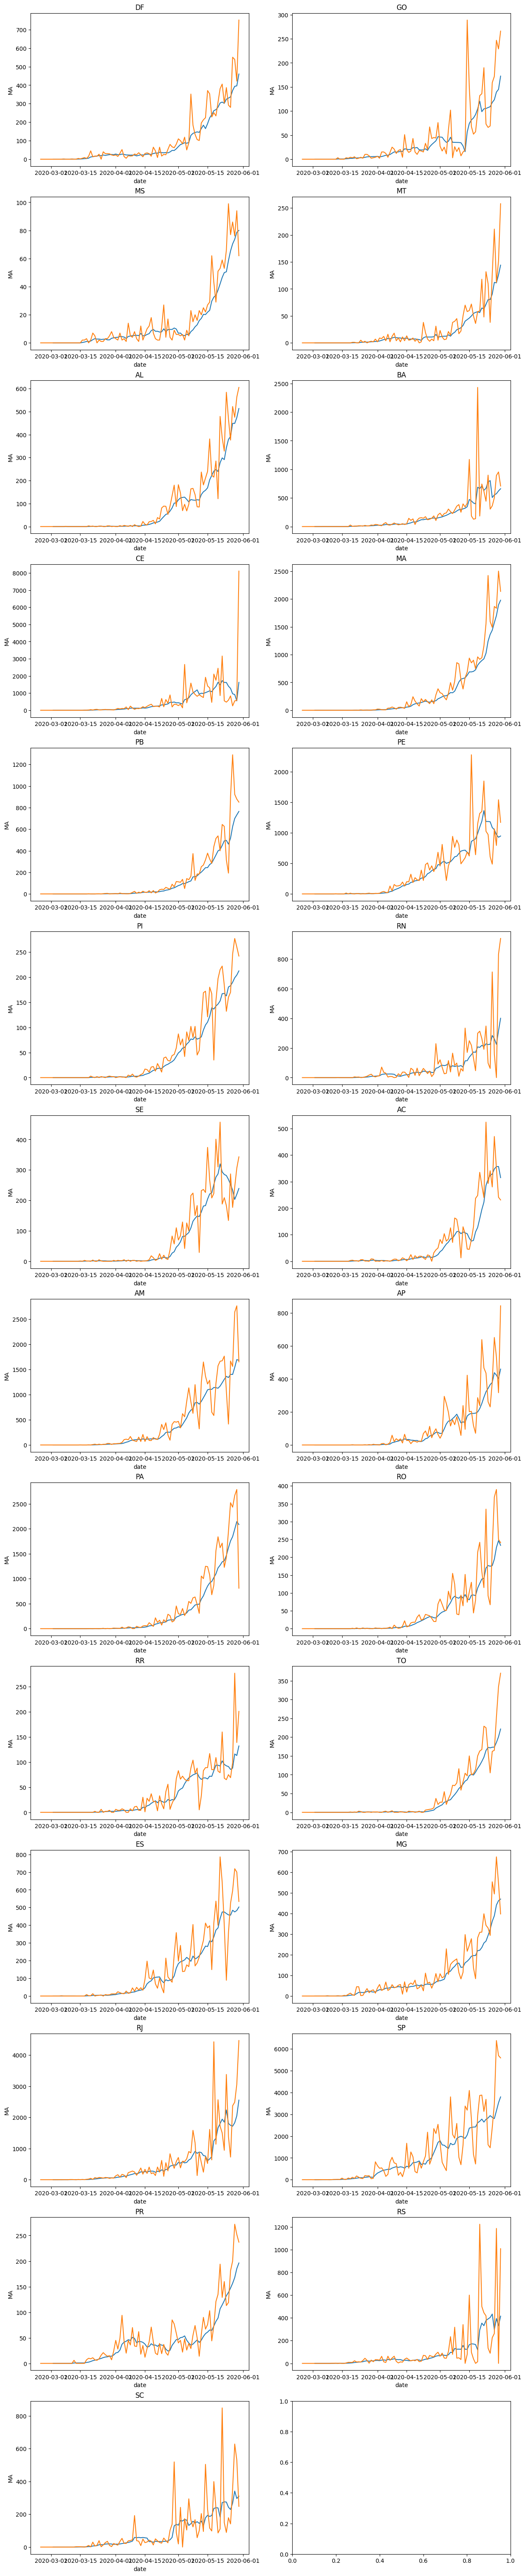

In [12]:
#Plotando timeseries de casos detectados por estado
list_states = df_alpha.state.unique().tolist()
fig, axes = plt.subplots(ncols=2, nrows=14, figsize=(15, 80))
df_alpha_2 = pd.DataFrame()

for state, ax in zip(list_states, axes.flat):
    df_time = pd.DataFrame(df_alpha[df_alpha.state == state])
    
    #Calculando média móvel (window = 7 = uma semana)
    df_time['MA'] = df_time["number_cases"].rolling(window=7).mean()
    df_time['state'] = state

    df_alpha_2 = pd.concat([df_alpha_2, df_time])

    sns.lineplot(data=df_time, x="date", y="MA", ax=ax).set(title=state)
    sns.lineplot(data=df_time, x="date", y="number_cases", ax=ax).set(title=state)
plt.show()

#### Por cidade 

#### Por estado

In [13]:
#Removendo o estado de SP da análise
df_alpha_no_sp = df_alpha[df_alpha["state"]!="SP"]

Rank por 1 caso

In [14]:
#Rank sem desempate na data
df_more_1 = df_alpha_no_sp[df_alpha_no_sp["cases"]>=1]
df_more_1 = df_more_1[~df_more_1.duplicated(subset=["state"])]
df_more_1["rank"] = df_more_1["date"].rank(method='dense').astype(int)
df_more_1.head()

date        region state  cases  deaths  number_cases  rank
265 2020-03-05       Sudeste    RJ    1.0       0           1.0     1
275 2020-03-06      Nordeste    BA    1.0       0           1.0     2
290 2020-03-06       Sudeste    ES    1.0       0           1.0     2
297 2020-03-07  Centro-Oeste    DF    1.0       0           1.0     3
328 2020-03-08      Nordeste    AL    1.0       0           1.0     4

Rank por 10 casos

In [15]:
#Rank sem desempate na data
df_more_10 = df_alpha_no_sp[df_alpha_no_sp["cases"]>=10]
df_more_10 = df_more_10[~df_more_10.duplicated(subset=["state"])]
df_more_10["rank"] = df_more_10["date"].rank(method='dense').astype(int)
df_more_10.head()


date        region state  cases  deaths  number_cases  rank
427 2020-03-11       Sudeste    RJ   13.0       0           5.0     1
540 2020-03-16  Centro-Oeste    DF   13.0       0           5.0     2
576 2020-03-17      Nordeste    PE   16.0       0          14.0     3
592 2020-03-17           Sul    RS   10.0       0           4.0     3
615 2020-03-18       Sudeste    MG   15.0       0           8.0     4

Rank média móvel 
 
- Será utilizado como parâmetros de corte de ranqueamento 3 valores: 0.5, 1.0 e 1.5

In [16]:
#Rank sem desempate na data com média móvel
list_df_ma = []
list_ma = [.5, 1, 1.5]

for ma in list_ma:
    ma_str = str(ma)
    df_ma = df_alpha_2[df_alpha_2["MA"]>=ma]
    df_ma = df_ma[~df_ma.duplicated(subset=["state"])]
    df_ma["rank"] = df_ma["date"].rank(method='dense').astype(int)
    df_ma["rank_type"] = ma
    list_df_ma.append(df_ma[["state","date" , "rank","MA","rank_type"]])

df_ma_sp = pd.concat(list_df_ma)
df_ma_sp.head()
    

state       date  rank        MA  rank_type
486    DF 2020-03-14     4  0.714286        0.5
568    GO 2020-03-17     6  0.857143        0.5
569    MS 2020-03-17     6  0.571429        0.5
759    MT 2020-03-24    13  1.000000        0.5
652    AL 2020-03-20     9  0.571429        0.5

Calculo de viagem de probabilidade por estado a partir do estado de SP

In [17]:
#Calculando probabilidade de viajar de SP para outros estados
df_prob_sp = df_prob[df_prob["uf_origem"]=="SP"] 
total_pass_sp = df_prob_sp["passageiros_total"].sum()
df_prob_sp_uf = pd.DataFrame(df_prob_sp.groupby(["uf_destino"])["passageiros_total"].sum())
df_prob_sp_uf["prob_viagem_sp"] = df_prob_sp_uf["passageiros_total"]/total_pass_sp
df_prob_sp_uf.head()


passageiros_total  prob_viagem_sp
uf_destino                                   
AC                      383.5    5.776338e-08
AL                    32390.5    4.878709e-06
AM                    84703.0    1.275810e-05
AP                      763.0    1.149243e-07
BA                  5475442.0    8.247198e-04

#### Correlação Rank vs Prob. de viagem

In [18]:
#Realizando merge de df
df_alpha_uf_1 = df_more_1.merge(df_prob_sp_uf, left_on="state", right_on = "uf_destino")
df_alpha_uf_10 = df_more_10.merge(df_prob_sp_uf, left_on="state", right_on = "uf_destino")
df_alpha_uf_ma = df_ma_sp.merge(df_prob_sp_uf, left_on="state", right_on = "uf_destino")

In [19]:
df_alpha_uf_ma.head()

state       date  rank        MA  rank_type  passageiros_total  \
0    DF 2020-03-14     4  0.714286        0.5          5673771.5   
1    DF 2020-03-15     3  1.000000        1.0          5673771.5   
2    DF 2020-03-16     3  1.714286        1.5          5673771.5   
3    GO 2020-03-17     6  0.857143        0.5          2391836.5   
4    GO 2020-03-18     6  1.142857        1.0          2391836.5   

   prob_viagem_sp  
0        0.000855  
1        0.000855  
2        0.000855  
3        0.000360  
4        0.000360

Avaliando correlacao com rank a partir de 1 caso

In [22]:
avaliar_corr(df_alpha_uf_1[["rank","prob_viagem_sp"]], "rank")

r      p
rank            1.00  0.000
prob_viagem_sp -0.63  0.001

Avaliando correlacao com rank a partir de 10 casos

In [23]:
df_alpha_uf_10 = df_alpha_uf_10[df_alpha_uf_10.state != "SP"]
avaliar_corr(df_alpha_uf_10[["rank","prob_viagem_sp"]], "rank")

r    p
rank            1.00  0.0
prob_viagem_sp -0.76  0.0

##### Avaliando correlação com rank a partir de média móvel

In [24]:
df_alpha_uf_ma = df_alpha_uf_ma[df_alpha_uf_ma.state != "SP"]

Média móvel de 0.5

In [25]:
df_alpha_uf_ma_5 = df_alpha_uf_ma[df_alpha_uf_ma["rank_type"]==.5]
avaliar_corr(df_alpha_uf_ma_5[["rank","prob_viagem_sp"]], "rank")

r    p
rank            1.00  0.0
prob_viagem_sp -0.81  0.0

Média móvel de 1.0

In [26]:
df_alpha_uf_ma_1 = df_alpha_uf_ma[df_alpha_uf_ma["rank_type"]==1]
avaliar_corr(df_alpha_uf_ma_1[["rank","prob_viagem_sp"]], "rank")

r    p
rank            1.00  0.0
prob_viagem_sp -0.77  0.0

Média móvel de 1.5

In [27]:
df_alpha_uf_ma_15 = df_alpha_uf_ma[df_alpha_uf_ma["rank_type"]==1.5]
avaliar_corr(df_alpha_uf_ma_15[["rank","prob_viagem_sp"]], "rank")

r    p
rank            1.00  0.0
prob_viagem_sp -0.76  0.0

### Variante Gamma

#### Análise Visual e Média Móvel

Antes do cálculo da correlação do ranking com a probabilidade de viagem, decidimos verificar a tendência de crescimento em cada estado. Isso foi necessário pois evita que uma cidade seja ranqueada somente por coincidência e não porque há um crescimento persistente de casos na cidade.

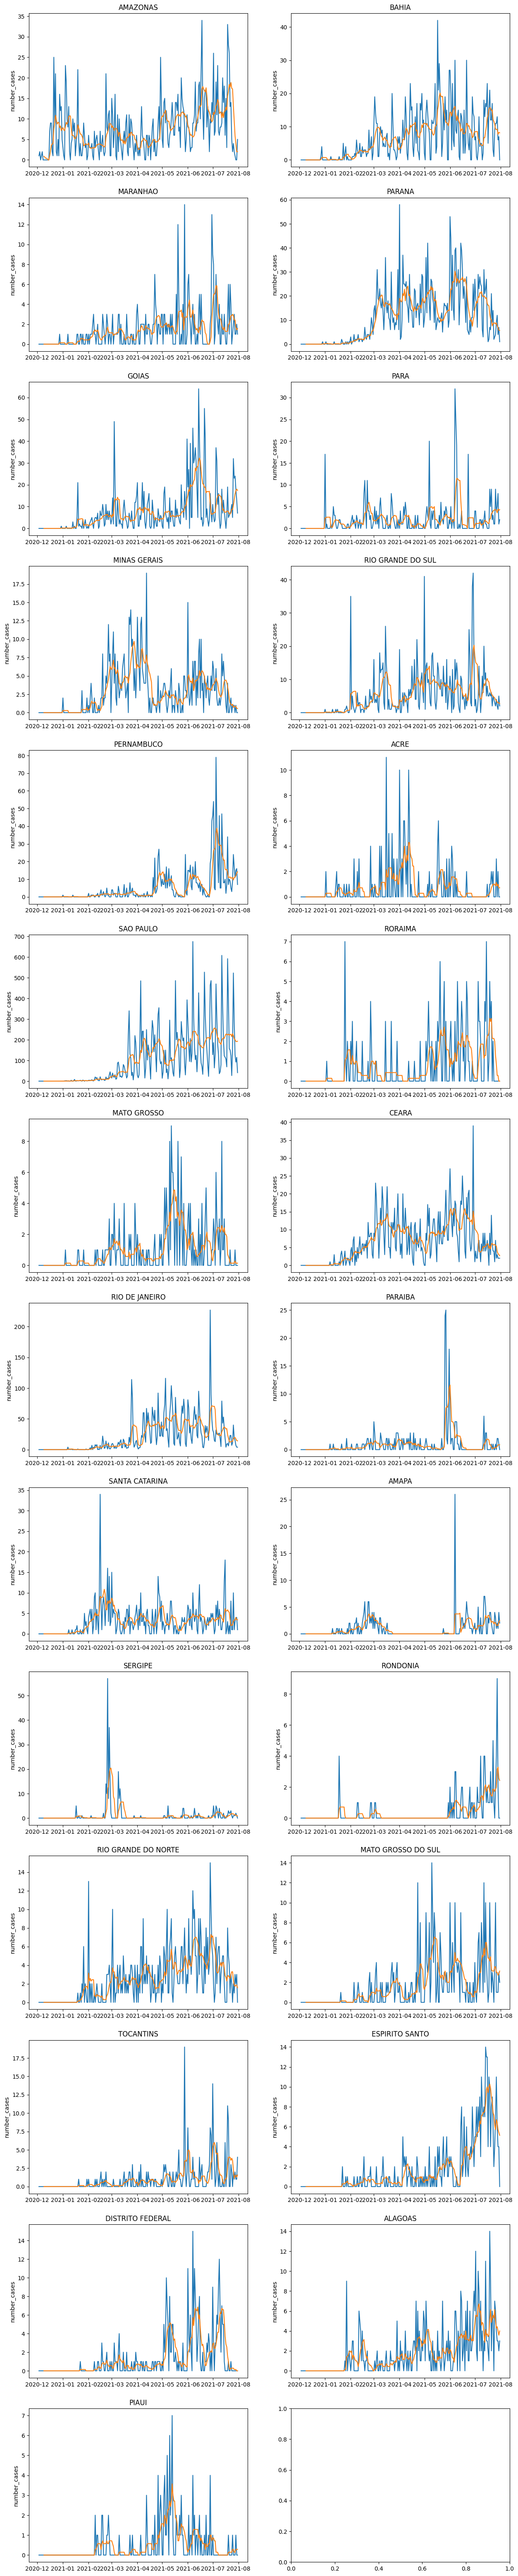

In [28]:
#Plotando timeseries de casos detectados por estado

list_states = df_gamma.state.unique().tolist()
list_uf = df_gamma.uf.unique().tolist()
fig, axes = plt.subplots(ncols=2, nrows=14, figsize=(15, 80))
df_gamma_2 = pd.DataFrame()

for state, uf, ax in zip(list_states,list_uf, axes.flat):
    df_state = df_gamma[df_gamma.state == state]
    #Agrupando casos no mesma data
    df_time = pd.DataFrame(df_state.groupby('Collection date').count()['Accession ID']).reset_index().rename(columns={"Accession ID": "number_cases"})
    
    #Adicionando data não presentes no dataset
    idx = pd.date_range('2020-12-03', '2021-07-31')
    df_time.index = pd.DatetimeIndex(df_time['Collection date'])
    df_time = df_time.reindex(idx, fill_value=0)
    
    #Calculando média móvel (window = uma semana = 7)
    df_time['MA'] = df_time["number_cases"].rolling(window=7).mean()
    df_time['MA_std'] = df_time["number_cases"].rolling(window=7).std()

    df_time['state'] = state
    df_time['uf'] = uf
    df_time['uf'] = uf

    df_gamma_2 = pd.concat([df_gamma_2, df_time])

    sns.lineplot(data=df_time, x=df_time.index, y="number_cases", ax=ax).set(title=state)
    sns.lineplot(data=df_time, x=df_time.index, y="MA", ax=ax).set(title=state)
plt.show()


#### Por cidade

#### Por estado

In [29]:
#Removendo o estado de AM da análise
df_gamma_no_am = df_gamma[df_gamma["uf"]!="AM"]

Rank por 1 caso

In [30]:
#Rank sem desempate na data - 1 caso
df_more_1 = df_gamma_no_am[df_gamma_no_am["cases"]>=1]
df_more_1 = df_more_1[~df_more_1.duplicated(subset=["state"])]
df_more_1["rank"] = df_more_1["Collection date"].rank(method='dense').astype(int)
df_more_1.head()

Accession ID Collection date Submission date  \
36465   EPI_ISL_2491697      2020-12-27      2021-06-11   
40302   EPI_ISL_2983332      2020-12-28      2021-07-16   
28302   EPI_ISL_9155325      2020-12-29      2022-01-27   
39359   EPI_ISL_4877300      2020-12-30      2021-10-05   
41282  EPI_ISL_11514230      2021-01-01      2022-03-28   

                                                Location      continent  \
36465          South America / Brazil / Bahia / Salvador  South America   
40302          South America / Brazil / Maranhao / Timon  South America   
28302    South America / Brazil / Parana / Foz do Iguacu  South America   
39359      South America / Brazil / Goias / Caldas Novas  South America   
41282  South America / Brazil / Para / Garrafao Do Norte  South America   

      country     state       municipality  uf nome_capital  case  cases  rank  
36465  Brazil     BAHIA           SALVADOR  BA     SALVADOR     1      1     1  
40302  Brazil  MARANHAO              TIMON  MA     SAO LUIS     1      1     2  
28302  Brazil    PARANA      FOZ DO IGUACU  PR     CURITIBA     1      1     3  
39359  Brazil     GOIAS       CALDAS NOVAS  GO      GOIANIA     1      1     4  
41282  Brazil      PARA  GARRAFAO DO NORTE  PA        BELEM     1      1     5

Rank por 10 casos

In [31]:
#Rank sem desempate na data
df_more_10 = df_gamma_no_am[df_gamma_no_am["cases"]>=10]
df_more_10 = df_more_10[~df_more_10.duplicated(subset=["state"])]
df_more_10["rank"] = df_more_10["Collection date"].rank(method='dense').astype(int)
df_more_10.head()

Accession ID Collection date Submission date  \
41264  EPI_ISL_11382294      2021-01-01      2022-03-24   
3580     EPI_ISL_940621      2021-01-14      2021-02-05   
38196   EPI_ISL_2187723      2021-01-18      2021-05-20   
44892   EPI_ISL_2661915      2021-01-21      2021-06-24   
36429   EPI_ISL_1067734      2021-01-23      2021-02-24   

                                                Location      continent  \
41264  South America / Brazil / Para / Concordia Do Para  South America   
3580      South America / Brazil / Sao Paulo / Sao Paulo  South America   
38196  South America / Brazil / Goias / Aparecida de ...  South America   
44892         South America / Brazil / Ceara / Fortaleza  South America   
36429                     South America / Brazil / Bahia  South America   

      country      state          municipality  uf nome_capital  case  cases  \
41264  Brazil       PARA     CONCORDIA DO PARA  PA        BELEM     1     10   
3580   Brazil  SAO PAULO             SAO PAULO  SP    SAO PAULO     1     10   
38196  Brazil      GOIAS  APARECIDA DE GOIANIA  GO      GOIANIA     1     10   
44892  Brazil      CEARA             FORTALEZA  CE    FORTALEZA     1     10   
36429  Brazil      BAHIA              SALVADOR  BA     SALVADOR     1     10   

       rank  
41264     1  
3580      2  
38196     3  
44892     4  
36429     5

Rank média móvel 
 
- Será utilizado como parâmetros de corte de ranqueamento 3 valores: 0.5, 1.0 e 1.5

In [32]:
#Rank sem desempate na data com média móvel
list_df_ma = []
list_ma = [.5, 1, 1.5]
df_gamma_2.reset_index(inplace=True)
df_gamma_2 = df_gamma_2.rename(columns = {'index':'date'})

for ma in list_ma:
    ma_str = str(ma)
    df_ma = df_gamma_2[df_gamma_2["MA"]>=ma]
    df_ma = df_ma[~df_ma.duplicated(subset=["state"])]
    df_ma["rank"] = df_ma.date.rank(method='dense').astype(int)
    
    #Descomentar caso queira desempate no Rank
    # df_ma['rank_date']=df_ma["date"].rank(method='dense',ascending=False).astype(int)
    # df_ma["rank"] = df_ma[["rank_date","MA"]].apply(tuple,axis=1)\
    #                     .rank(method='dense',ascending=False).astype(int)

    df_ma["rank_type"] = ma


    list_df_ma.append(df_ma[["uf","date" , "rank","MA","rank_type"]])

df_ma_am = pd.concat(list_df_ma)
df_ma_am.head()

uf       date  rank        MA  rank_type
6     AM 2020-12-09     1  0.857143        0.5
266   BA 2020-12-28     2  0.714286        0.5
533   MA 2021-01-23    11  0.571429        0.5
777   PR 2021-01-26    14  0.571429        0.5
1007  GO 2021-01-15     7  0.571429        0.5

Calculo de viagem de probabilidade por estado a partir do estado de AM

In [33]:
#Calculando probabilidade de viajar de AM para outros estados
df_prob_am = df_prob[df_prob["uf_origem"]=="AM"] 
total_pass_am = df_prob_am["passageiros_total"].sum()
df_prob_am_uf = pd.DataFrame(df_prob_am.groupby(["uf_destino"])["passageiros_total"].sum())
df_prob_am_uf["prob_viagem_am"] = df_prob_am_uf["passageiros_total"]/total_pass_am
df_prob_am_uf

passageiros_total  prob_viagem_am
uf_destino                                   
AC                    23733.0    1.942677e-02
AL                       43.0    3.519787e-05
AM                   227824.0    1.864865e-01
AP                        9.0    7.366995e-06
BA                      339.0    2.774901e-04
CE                   111534.0    9.129671e-02
DF                   282951.0    2.316110e-01
ES                       29.0    2.373810e-05
GO                      413.0    3.380632e-04
MA                     1663.0    1.361257e-03
MG                       38.0    3.110509e-05
MS                       35.0    2.864943e-05
MT                       82.0    6.712151e-05
PA                   191966.0    1.571347e-01
PB                        1.0    8.185550e-07
PE                    54315.0    4.445982e-02
PI                       57.0    4.665764e-05
PR                       24.0    1.964532e-05
RJ                    94264.0    7.716027e-02
RO                    99404.0    8.136764e-02
RR                    43835.0    3.588136e-02
RS                     1608.0    1.316236e-03
SC                      123.0    1.006823e-04
SP                    87206.0    7.138291e-02
TO                      169.0    1.383358e-04

In [34]:
df_prob_am_uf.shape
#Isso significa que a 7 estados estão fora da contagem pois não há fluxo direto de manaus para esses estados, ao menos nos nossos dados

(25, 2)

#### Correlação Rank vs Prob. de viagem

In [35]:
df_gamma_uf_1 = df_more_1.merge(df_prob_am_uf, left_on="uf", right_on = "uf_destino")
df_gamma_uf_10 = df_more_10.merge(df_prob_am_uf, left_on="uf", right_on = "uf_destino")
df_gamma_uf_ma = df_ma_am.merge(df_prob_am_uf, left_on="uf", right_on = "uf_destino")

# df_gamma_uf_10 = df_gamma_uf_10[df_gamma_uf_10.uf!="AM"]
# df_gamma_uf_1 = df_gamma_uf_1[df_gamma_uf_1.uf!="AM"]


In [36]:
df_gamma_uf_10.head()

Accession ID Collection date Submission date  \
0  EPI_ISL_11382294      2021-01-01      2022-03-24   
1    EPI_ISL_940621      2021-01-14      2021-02-05   
2   EPI_ISL_2187723      2021-01-18      2021-05-20   
3   EPI_ISL_2661915      2021-01-21      2021-06-24   
4   EPI_ISL_1067734      2021-01-23      2021-02-24   

                                            Location      continent country  \
0  South America / Brazil / Para / Concordia Do Para  South America  Brazil   
1     South America / Brazil / Sao Paulo / Sao Paulo  South America  Brazil   
2  South America / Brazil / Goias / Aparecida de ...  South America  Brazil   
3         South America / Brazil / Ceara / Fortaleza  South America  Brazil   
4                     South America / Brazil / Bahia  South America  Brazil   

       state          municipality  uf nome_capital  case  cases  rank  \
0       PARA     CONCORDIA DO PARA  PA        BELEM     1     10     1   
1  SAO PAULO             SAO PAULO  SP    SAO PAULO     1     10     2   
2      GOIAS  APARECIDA DE GOIANIA  GO      GOIANIA     1     10     3   
3      CEARA             FORTALEZA  CE    FORTALEZA     1     10     4   
4      BAHIA              SALVADOR  BA     SALVADOR     1     10     5   

   passageiros_total  prob_viagem_am  
0           191966.0        0.157135  
1            87206.0        0.071383  
2              413.0        0.000338  
3           111534.0        0.091297  
4              339.0        0.000277

Avaliando correlacao com rank a partir de 1 casos

In [37]:
avaliar_corr(df_gamma_uf_1[["rank","prob_viagem_am"]], "rank")

r      p
rank            1.00  0.000
prob_viagem_am -0.16  0.465

Avaliando correlacao com rank a partir de 10 casos

In [38]:
avaliar_corr(df_gamma_uf_10[["rank","prob_viagem_am"]], "rank")

r      p
rank            1.00  0.000
prob_viagem_am -0.24  0.269

##### Avaliando correlação com rank a partir de média móvel

In [39]:
df_gamma_uf_ma = df_gamma_uf_ma[df_gamma_uf_ma.uf != "AM"]

Média móvel de 0.5

In [40]:
df_gamma_uf_ma_5 = df_gamma_uf_ma[df_gamma_uf_ma["rank_type"]==.5]
avaliar_corr(df_gamma_uf_ma_5[["rank","prob_viagem_am"]], "rank")

r      p
rank            1.00  0.000
prob_viagem_am -0.45  0.028

Média móvel de 1.0

In [41]:
df_gamma_uf_ma_1 = df_gamma_uf_ma[df_gamma_uf_ma["rank_type"]==1]
avaliar_corr(df_gamma_uf_ma_1[["rank","prob_viagem_am"]], "rank")

r      p
rank            1.00  0.000
prob_viagem_am -0.28  0.187

Média móvel de 1.5

In [42]:
df_gamma_uf_ma_15 = df_gamma_uf_ma[df_gamma_uf_ma["rank_type"]==1.5]
avaliar_corr(df_gamma_uf_ma_15[["rank","prob_viagem_am"]], "rank")

r      p
rank            1.00  0.000
prob_viagem_am -0.26  0.227

## Rotas Mais prováveis

Encontrar rotas mais prováveis para as capitais brasileiras

Carregando dados calculado no Neo4j

In [44]:
df_path_ma = pd.read_csv("./manaus_cap.csv")
df_path_sp = pd.read_csv("./saopaulo_cap.csv")

### Partindo de São Paulo

In [45]:
df_path_sp.totalCost = df_path_sp.totalCost * (-1)
df_path_sp = df_path_sp.merge(df_municipio[["cod_mun", "nome_mun", "uf"]], left_on="cod_mun_destino", right_on="cod_mun")
df_path_sp.head()

index  cod_mun_origem  cod_mun_destino     totalCost  \
0      0         3550308          2800308  1.090897e-04   
1      0         3550308          1501402  1.081379e-05   
2      0         3550308          3106200  2.523476e-01   
3      0         3550308          1400100  7.752475e-07   
4      0         3550308          5300108  5.045489e-03   

                     cod_nos  \
0          [3550308,2800308]   
1  [3550308,5300108,1501402]   
2          [3550308,3106200]   
3  [3550308,5300108,1400100]   
4          [3550308,5300108]   

                                               costs  cod_mun        nome_mun  \
0                      [-1.0,-1.0908973970132802E-4]  2800308         Aracaju   
1  [-1.0,-0.005045488694853777,-1.081379456485902...  1501402           Belém   
2                         [-1.0,-0.2523476301004422]  3106200  Belo Horizonte   
3  [-1.0,-0.005045488694853777,-7.752474588258609...  1400100       Boa Vista   
4                       [-1.0,-0.005045488694853777]  5300108        Brasília   

   uf  
0  SE  
1  PA  
2  MG  
3  RR  
4  DF

#### Correlação Prob. Path vs Rank de Média Móvel

In [46]:
df_alpha_path_ma = df_ma_sp.merge(df_path_sp, left_on="state", right_on = "uf")
df_alpha_path_ma = df_alpha_path_ma[df_alpha_path_ma.uf != "SP"]
df_alpha_path_ma.head()

state       date  rank        MA  rank_type  index  cod_mun_origem  \
0    DF 2020-03-14     4  0.714286        0.5      0         3550308   
1    DF 2020-03-15     3  1.000000        1.0      0         3550308   
2    DF 2020-03-16     3  1.714286        1.5      0         3550308   
3    GO 2020-03-17     6  0.857143        0.5      0         3550308   
4    GO 2020-03-18     6  1.142857        1.0      0         3550308   

   cod_mun_destino  totalCost                    cod_nos  \
0          5300108   0.005045          [3550308,5300108]   
1          5300108   0.005045          [3550308,5300108]   
2          5300108   0.005045          [3550308,5300108]   
3          5208707   0.001532  [3550308,5300108,5208707]   
4          5208707   0.001532  [3550308,5300108,5208707]   

                                               costs  cod_mun  nome_mun  uf  
0                       [-1.0,-0.005045488694853777]  5300108  Brasília  DF  
1                       [-1.0,-0.005045488694853777]  5300108  Brasília  DF  
2                       [-1.0,-0.005045488694853777]  5300108  Brasília  DF  
3  [-1.0,-0.005045488694853777,-0.001531769626308...  5208707   Goiânia  GO  
4  [-1.0,-0.005045488694853777,-0.001531769626308...  5208707   Goiânia  GO

Calculando Correlação

Média móvel de 0.5

In [47]:
df_alpha_path_ma_5 = df_alpha_path_ma[df_alpha_path_ma["rank_type"]==.5]
avaliar_corr(df_alpha_path_ma_5[["rank","totalCost"]], "rank")

r    p
rank       1.00  0.0
totalCost -0.76  0.0

Média móvel de 1.0

In [48]:
df_alpha_path_ma_1 = df_alpha_path_ma[df_alpha_path_ma["rank_type"]==1]
avaliar_corr(df_alpha_path_ma_1[["rank","totalCost"]], "rank")

r    p
rank       1.00  0.0
totalCost -0.74  0.0

Média móvel de 1.5

In [49]:
df_alpha_path_ma_15 = df_alpha_path_ma[df_alpha_path_ma["rank_type"]==1.5]
avaliar_corr(df_alpha_path_ma_15[["rank","totalCost"]], "rank")

r    p
rank       1.00  0.0
totalCost -0.77  0.0

### Partindo de Manaus

In [50]:
df_path_ma.totalCost = df_path_ma.totalCost * (-1)
df_path_ma = df_path_ma.merge(df_municipio[["cod_mun", "nome_mun", "uf"]], left_on="cod_mun_destino", right_on="cod_mun")
df_path_ma.head()

index  cod_mun_origem  cod_mun_destino  totalCost  \
0      0         1302603          2800308   0.000059   
1      0         1302603          1501402   0.094715   
2      0         1302603          3106200   0.008572   
3      0         1302603          1400100   0.029625   
4      0         1302603          5300108   0.191206   

                     cod_nos  \
0  [1302603,3509502,2800308]   
1          [1302603,1501402]   
2  [1302603,3509502,3106200]   
3          [1302603,1400100]   
4          [1302603,5300108]   

                                               costs  cod_mun        nome_mun  \
0  [-1.0,-0.05870992922300751,-5.8612883301462986...  2800308         Aracaju   
1                        [-1.0,-0.09471512640679622]  1501402           Belém   
2   [-1.0,-0.05870992922300751,-0.00857160085360055]  3106200  Belo Horizonte   
3                        [-1.0,-0.02962529926891371]  1400100       Boa Vista   
4                        [-1.0,-0.19120635151277585]  5300108        Brasília   

   uf  
0  SE  
1  PA  
2  MG  
3  RR  
4  DF

#### Correlação Prob. Path vs Rank de Média Móvel

In [51]:
df_gamma_path_ma = df_ma_am.merge(df_path_ma, left_on="uf", right_on = "uf")
df_gamma_path_ma = df_gamma_path_ma[df_gamma_path_ma.uf != "AM"]
df_gamma_path_ma.head()


uf       date  rank        MA  rank_type  index  cod_mun_origem  \
3  BA 2020-12-28     2  0.714286        0.5      0         1302603   
4  BA 2021-01-25     6  1.000000        1.0      0         1302603   
5  BA 2021-01-26     6  1.571429        1.5      0         1302603   
6  MA 2021-01-23    11  0.571429        0.5      0         1302603   
7  MA 2021-02-07    12  1.285714        1.0      0         1302603   

   cod_mun_destino  totalCost                    cod_nos  \
3          2927408   0.001306  [1302603,3509502,2927408]   
4          2927408   0.001306  [1302603,3509502,2927408]   
5          2927408   0.001306  [1302603,3509502,2927408]   
6          2111300   0.000070  [1302603,5300108,2111300]   
7          2111300   0.000070  [1302603,5300108,2111300]   

                                               costs  cod_mun  nome_mun  
3  [-1.0,-0.05870992922300751,-0.0013064633022601...  2927408  Salvador  
4  [-1.0,-0.05870992922300751,-0.0013064633022601...  2927408  Salvador  
5  [-1.0,-0.05870992922300751,-0.0013064633022601...  2927408  Salvador  
6   [-1.0,-0.19120635151277585,-6.97493806043272E-5]  2111300  São Luís  
7   [-1.0,-0.19120635151277585,-6.97493806043272E-5]  2111300  São Luís

Calculando correlação

Média móvel de 0.5

In [52]:
df_gamma_path_ma_5 = df_gamma_path_ma[df_gamma_path_ma["rank_type"]==.5]
avaliar_corr(df_gamma_path_ma_5[["rank","totalCost"]], "rank")

r      p
rank       1.00  0.000
totalCost -0.25  0.211

Média móvel de 1.0

In [53]:
df_gamma_path_ma_1 = df_gamma_path_ma[df_gamma_path_ma["rank_type"]==1]
avaliar_corr(df_gamma_path_ma_1[["rank","totalCost"]], "rank")

r      p
rank       1.00  0.000
totalCost -0.34  0.094

Média móvel de 1.5

In [54]:
df_gamma_path_ma_15 = df_gamma_path_ma[df_gamma_path_ma["rank_type"]==1.5]
avaliar_corr(df_gamma_path_ma_15[["rank","totalCost"]], "rank")

r      p
rank       1.00  0.000
totalCost -0.31  0.124

Colocando somente capitais no cálculo

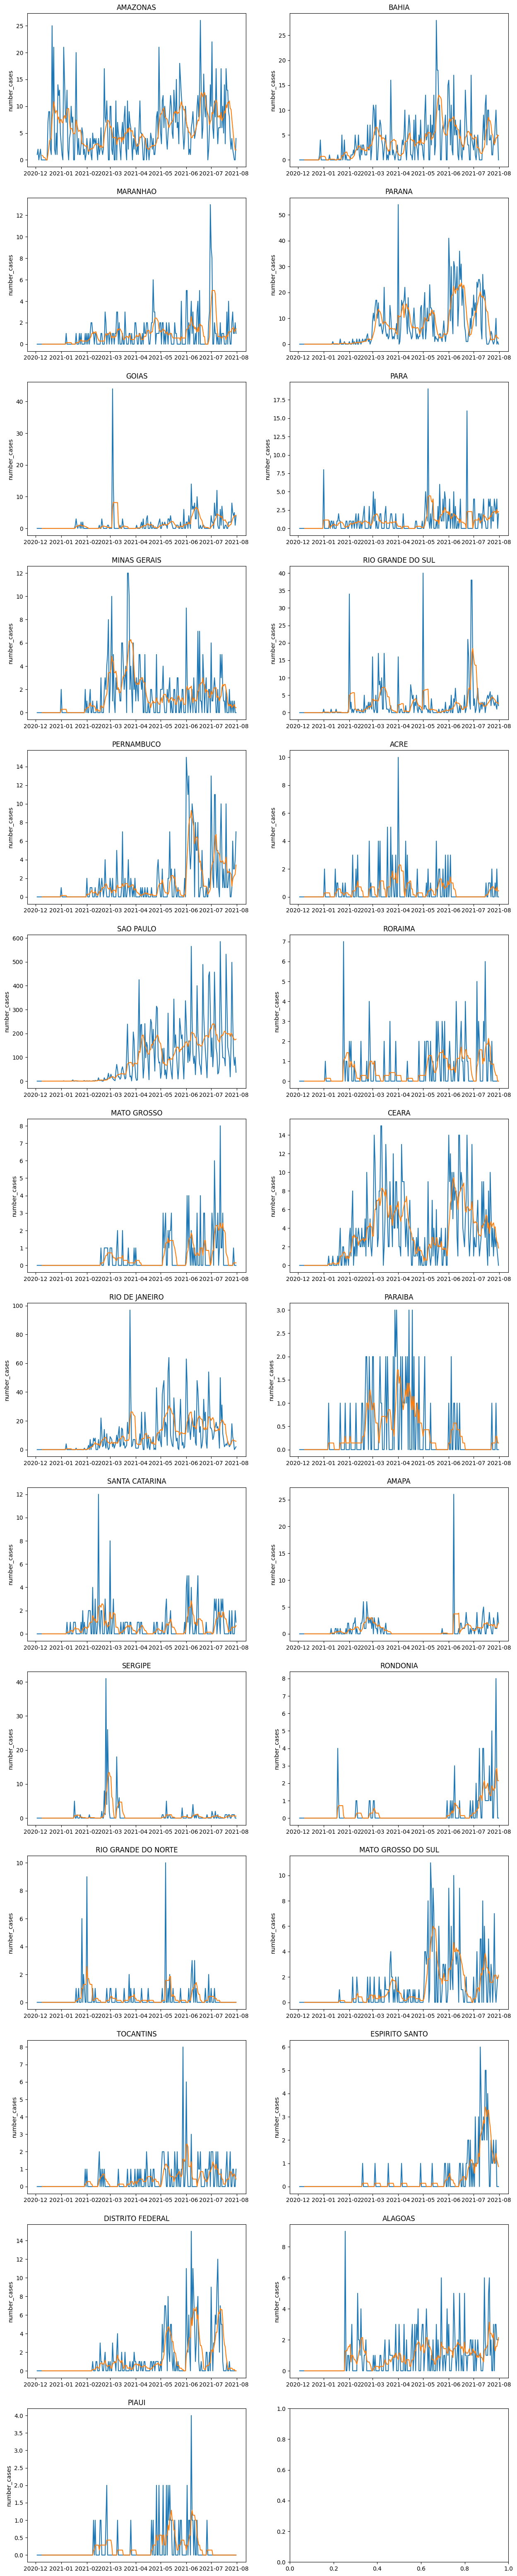

In [55]:
#Recalculando média móvel somente para capital
list_states = df_gamma.state.unique().tolist()
list_uf = df_gamma.uf.unique().tolist()
fig, axes = plt.subplots(ncols=2, nrows=14, figsize=(15, 80))
df_gamma_cp = df_gamma[df_gamma.nome_capital==df_gamma.municipality]
df_gamma_2 = pd.DataFrame()

for state, uf, ax in zip(list_states,list_uf, axes.flat):
    df_state = df_gamma_cp[df_gamma_cp.state == state]
    #Agrupando casos no mesma data
    df_time = pd.DataFrame(df_state.groupby('Collection date').count()['Accession ID']).reset_index().rename(columns={"Accession ID": "number_cases"})
    
    #Adicionando data não presentes no dataset
    idx = pd.date_range('2020-12-03', '2021-07-31')
    df_time.index = pd.DatetimeIndex(df_time['Collection date'])
    df_time = df_time.reindex(idx, fill_value=0)
    
    #Calculando média móvel (window = uma semana = 7)
    df_time['MA'] = df_time["number_cases"].rolling(window=7).mean()
    df_time['MA_std'] = df_time["number_cases"].rolling(window=7).std()

    df_time['state'] = state
    df_time['uf'] = uf
    df_time['uf'] = uf

    df_gamma_2 = pd.concat([df_gamma_2, df_time])

    sns.lineplot(data=df_time, x=df_time.index, y="number_cases", ax=ax).set(title=state)
    sns.lineplot(data=df_time, x=df_time.index, y="MA", ax=ax).set(title=state)
plt.show()

In [56]:
df_gamma_2.head()

Collection date  number_cases  MA  MA_std     state  uf
2020-12-03  2020-12-03 00:00:00             1 NaN     NaN  AMAZONAS  AM
2020-12-04  2020-12-04 00:00:00             2 NaN     NaN  AMAZONAS  AM
2020-12-05                    0             0 NaN     NaN  AMAZONAS  AM
2020-12-06  2020-12-06 00:00:00             1 NaN     NaN  AMAZONAS  AM
2020-12-07  2020-12-07 00:00:00             2 NaN     NaN  AMAZONAS  AM

In [57]:
#Rank sem desempate na data com média móvel
df_ma = df_gamma_2[(df_gamma_2["MA"]>=.5) & (df_gamma_2["uf"]!="AM")]
df_ma = df_ma[~df_ma.duplicated(subset=["uf"])]
df_ma["rank"] = df_ma["Collection date"].rank(method='dense').astype(int)
df_ma.head()

Collection date  number_cases        MA    MA_std     state  \
2020-12-28  2020-12-28 00:00:00             4  0.714286  1.496026     BAHIA   
2021-02-05  2021-02-05 00:00:00             1  0.571429  0.534522  MARANHAO   
2021-02-07  2021-02-07 00:00:00             1  0.571429  0.786796    PARANA   
2021-01-19  2021-01-19 00:00:00             3  0.571429  1.133893     GOIAS   
2021-01-01  2021-01-01 00:00:00             8  1.142857  3.023716      PARA   

            uf  rank  
2020-12-28  BA     1  
2021-02-05  MA    14  
2021-02-07  PR    16  
2021-01-19  GO     7  
2021-01-01  PA     2

In [58]:
df_gamma_path_ma = df_ma.merge(df_path_ma, left_on="uf", right_on = "uf")
df_gamma_path_ma.head()

Collection date  number_cases        MA    MA_std     state  uf  rank  \
0  2020-12-28 00:00:00             4  0.714286  1.496026     BAHIA  BA     1   
1  2021-02-05 00:00:00             1  0.571429  0.534522  MARANHAO  MA    14   
2  2021-02-07 00:00:00             1  0.571429  0.786796    PARANA  PR    16   
3  2021-01-19 00:00:00             3  0.571429  1.133893     GOIAS  GO     7   
4  2021-01-01 00:00:00             8  1.142857  3.023716      PARA  PA     2   

   index  cod_mun_origem  cod_mun_destino  totalCost  \
0      0         1302603          2927408   0.001306   
1      0         1302603          2111300   0.000070   
2      0         1302603          4106902   0.000627   
3      0         1302603          5208707   0.058049   
4      0         1302603          1501402   0.094715   

                             cod_nos  \
0          [1302603,3509502,2927408]   
1          [1302603,5300108,2111300]   
2  [1302603,5300108,3550308,4106902]   
3          [1302603,5300108,5208707]   
4                  [1302603,1501402]   

                                               costs  cod_mun  nome_mun  
0  [-1.0,-0.05870992922300751,-0.0013064633022601...  2927408  Salvador  
1   [-1.0,-0.19120635151277585,-6.97493806043272E-5]  2111300  São Luís  
2  [-1.0,-0.19120635151277585,-0.0056306579273352...  4106902  Curitiba  
3  [-1.0,-0.19120635151277585,-0.058048704361035375]  5208707   Goiânia  
4                        [-1.0,-0.09471512640679622]  1501402     Belém

In [59]:
df_gamma_path_ma = df_gamma_path_ma[df_gamma_path_ma.uf != "AM"]
avaliar_corr(df_gamma_path_ma[["rank","totalCost"]], "rank")

r      p
rank       1.00  0.000
totalCost -0.33  0.099